In [29]:
# 导入包
import time
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import numpy as np
from PIL import Image

# 绘图函数

In [30]:
def draw(x_aix,x_aix_num,x_data,y_data,y1_data,img_name,dataset_model,y_aix=1,y_aix_num=11,type='acc'):
    
    """
    
    x_aix (int):横轴最大值
    x_aix_num (int):横轴间距
    x_data (list)：横轴数据
    y_data (list)：纵轴曲线1（初始化）的数据
    y1_data (list)：纵轴曲线2（迁移学习）的数据
    img_name (string)：保存图像的名字
    dataset_model (string)：训练的模型名字
    y_aix (int)：纵轴最大值，默认为1
    y_aix_num (int)：纵轴间距，默认为11，中间10个间隙
    
    """
    
    plt.figure()
    # 横轴标签名称
    plt.xlabel('epoch')
    # 纵轴标签名称
    if type=='loss':
        plt.ylabel('Loss')
    else:
        plt.ylabel('Accuary')
    #限制横轴、纵轴的取值范围
    plt.xlim(0,x_aix)
    plt.ylim(0,y_aix)
    # 按设置分隔横轴、纵轴
    new_ticks_x = np.linspace(0,x_aix,x_aix_num)
    new_ticks_y = np.linspace(0,y_aix,y_aix_num)
    # 设置横纵轴
    plt.xticks(new_ticks_x)
    plt.yticks(new_ticks_y)

    # 根据数据绘制图像
    l1,=plt.plot(x_data,y_data,label="{}-init".format(dataset_model))
    l2,=plt.plot(x_data,y1_data,label="{}-trans".format(dataset_model),color='red')
    # 设置标注
    plt.legend(handles=[l1,l2,],loc='best')
    
    # 右边框，上边框消失
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    # 设置横纵均从0开始
    ax.spines['bottom'].set_position(('data',0))
    ax.spines['left'].set_position(('data',0))
    # 设置图像背景风格
    ax.yaxis.grid(color='k',
                  linestyle='--',
                  linewidth=1,
                  alpha=0.3)
    # 保存图像，并显示
    plt.savefig("./{}".format(img_name))
    plt.show()

# 读训练数据集的csv文件

In [31]:
labels_dataframe = pd.read_csv('../input/classify-leaves/train.csv')

# 看一下格式

In [32]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


# 给标签排序，顺便制作”类-序号“的字典

In [33]:

# 给label排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_class = len(leaves_labels)
# 制作”类-序号“字典，为了训练网络
class_to_num = dict(zip(leaves_labels,range(n_class)))

#class_to_num
"""{'abies_concolor': 0,'abies_nordmanniana': 1,'acer_campestre': 2,'acer_ginnala': 3,'acer_griseum': 4,}"""

"{'abies_concolor': 0,'abies_nordmanniana': 1,'acer_campestre': 2,'acer_ginnala': 3,'acer_griseum': 4,}"

# 制作”序号-类“的字典

In [34]:
#  制作”序号-类“的字典，为验证做准备
num_to_class = {v:x for x,v in class_to_num.items()}

# 继承pytorch的Dataset，创建自己的dataset

In [35]:
class LeavesData(Dataset):
    def __init__(self,csv_path,file_path,mode='train',valid_ratio=0.2,
                 resize_height=256, resize_width=256):
        """
        csv_path (string):csv文件路径
        file_path (string):图像文件所在路径
        mode (string):训练模式还是测试模式
        valid_ratio (float): 验证集比例 （验证集和训练集在一个csv文件里，我们按照比例选择）
        
        """
        
        self.resize_height = resize_height
        self.resize_width = resize_width
        
        self.file_path = file_path
        self.mode = mode
        
        # 读取csv文件，去掉表头部分(将表头按第一行开始从0，同时设置列序号0，1)
        self.data_info = pd.read_csv(csv_path,header=None)
        # 计算length，需要减去第一行表头
        self.data_len = len(self.data_info.index)-1
        # 计算训练的length
        self.train_len = int(self.data_len *(1-valid_ratio))
        
        if mode == 'train':
            # 从序号为1的行开始，0表示第一例，取训练数据的文件名imges/***.jpg
            self.train_img =np.asarray(self.data_info.iloc[1:self.train_len,0])
            # 从序号为1的行开始，1表示第二例，取训练数据的标签
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len,1])
            
            self.img_arr = self.train_img
            
            self.labels_arr = self.train_label
        elif mode == 'valid':
            # 从序号为训练集的结束行开始，取验证数据的文件名
            self.valid_img = np.asarray(self.data_info.iloc[self.train_len:,0])
            # 从序号为训练集的结束行开始，取验证数据的标签
            self.valid_labels = np.asarray(self.data_info.iloc[self.train_len:,1])
            
            self.img_arr = self.valid_img
            
            self.labels_arr = self.valid_labels
        elif mode == 'test':
            # 测试数据csv文件只有一列image文件名
            self.test_img = np.asarray(self.data_info.iloc[1:,0])
            
            self.img_arr = self.test_img
            
        self.real_len = len(self.img_arr)
        #  打印读取信息
        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode , self.real_len))
        
    def __getitem__(self,index):
        #  从image_arr中得到索引对应的文件名    
        single_image_name = self.img_arr[index]
        #  读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)
        
        #  设置好需要对图像进行的操作、如格式转换totensor，重绘大小，水平翻转
        if self.mode == 'train':
            transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                           transforms.RandomHorizontalFlip(0.5)])
        #  验证和测试的时候不对图像进行过多的处理，不进行数据增强    
        else:
            transform = transforms.Compose([transforms.Resize((224,224)),
                                           transforms.ToTensor()])
            
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的标签（string）
            label = self.labels_arr[index]
            # 转换成对应的序号
            number_label = class_to_num[label]
            
            return  img_as_img,number_label   #  返回每一个index对应的图片数据和label序号
    def __len__(self):
        return self.real_len

# 设置超参数

In [36]:
batch_size = 32   # 一个batch的数量

num_epoch_30=30   #总共多少个epoch

num_class_176 = 176    # 任务区分的类别数

num_print_100 = 100    # 多少个batch打印一次信息

lr_rate = 3e-4     # 学习率

# 设置dataset

In [37]:
train_path = '../input/classify-leaves/train.csv' #  训练数据的path
test_path='../input/classify-leaves/test.csv'   #   测试数据的path
img_path='../input/classify-leaves/'  # 照片的path，由于csv文件中已经文件名，故知道这一级目录

train_dataset = LeavesData(train_path,img_path,mode='train')
test_dataset = LeavesData(test_path,img_path,mode='test')
valid_dataset = LeavesData(train_path,img_path,mode='valid')

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)


# 设置dataloader

In [38]:
# 其中我们训练数据的数据采用随机取
train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_iter = DataLoader(valid_dataset,batch_size=batch_size)
test_iter = DataLoader(test_dataset,batch_size=batch_size)

# GPU与CPU的选择

In [39]:
# 选择gpu上训练网络，如果gpu不可用，则用cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 设置模型

In [40]:
# 初始化函数模型
model_init = torchvision.models.resnet50(num_classes=num_class_176)

# 迁移学习，冻结部分层
model_trans =torchvision.models.resnet50(pretrained=True)
# 最后一层全连接层换掉
in_features = model_trans.fc.in_features
model_trans.fc = nn.Linear(in_features,num_class_176)
# 冻结10层（一层：conv+bn）
for i,para in enumerate(model_trans.parameters()):
    if i==30:
        break
    para.requires_grad=False
# 将模型放到gpu/cpu上
model_trans=model_trans.to(device)
model_init = model_init.to(device)

# 设置损失函数、优化器、学习率策略

In [41]:
#  损失函数
losser = nn.CrossEntropyLoss() #交叉熵损失
#优化器Adam，权重衰减指数1e-6
trainer_trans =torch.optim.Adam(model_trans.parameters(),lr=lr_rate,weight_decay=1e-6)
trainer_init = torch.optim.Adam(model_init.parameters(),lr_rate,weight_decay=1e-6)
#用余弦退火更新学习率，一般周期为10，最小值为0
scheduler_trans = torch.optim.lr_scheduler.CosineAnnealingLR(trainer_trans, T_max=10, eta_min=0, last_epoch=-1)
schedule_init = torch.optim.lr_scheduler.CosineAnnealingLR(trainer_init, T_max=10, eta_min=0, last_epoch=-1)

# 训练与验证

In [42]:

start = time.time()
epoch_acc_trans=[]    # 统计迁移学习的验证集，正确率  
epoch_acc_init=[]     # 统计初始化参数的验证集，正确率
epoch_trans_ls=[]  # 统计迁移学习的损失
epoch_init_ls = [] # 统计初始化的损失
epoch_x =[]     # X轴数据

best_acc=0

for epoch in range(num_epoch_30):
    print("=====================================train================================")
    start1 = time.time()
    running_loss_trans = 0.0  # 统计损失
    running_init_loss = 0.0
    loss_init_epoch=[]           # 统计损失，用于
    loss_trans_epoch=[]
    train_acc_trans = []            # 统计训练数据集的正确率
    train_acc_init= []
    total = 0.0               # 统计总共参与的样本数
    model_trans.train()
    model_init.train()
    for i,(inputs,labels) in enumerate(train_iter):    #  取batch_size数据集
        
        inputs,labels = inputs.to(device),labels.to(device)
        
        outputs_trans = model_trans(inputs)
        outputs_init = model_init(inputs)
        
        loss_trans=losser(outputs_trans,labels)
        loss_init = losser(outputs_init,labels)
        
        trainer_trans.zero_grad()
        loss_trans.backward()
        trainer_trans.step()
        
        trainer_init.zero_grad()
        loss_init.backward()
        trainer_init.step()
        
        acc_trans = (outputs_trans.argmax(dim=1)==labels).sum() #  统计迁移学习训练数据的正确数
        train_acc_trans.append(acc_trans)
        acc_init = (outputs_init.argmax(dim=1)==labels).sum()
        train_acc_init.append(acc_init)
        total +=inputs.size(0)
        running_loss_trans+=loss_trans
        running_init_loss+=loss_init
        loss_init_epoch.append(running_init_loss.cpu().item())
        loss_trans_epoch.append(running_loss_trans.cpu().item())
        if (i+1)%num_print_100 ==0:
            print("{} epoch {} 次：\nloss_trans：{}\nloss_init:{}".format(epoch+1,i+1
                                                                       ,running_loss_trans/num_print_100
                                                                      ,running_init_loss/num_print_100))
            running_loss_trans=0.0
            running_init_loss=0.0
    epoch_trans_ls.append(sum(loss_trans_epoch)/len(train_dataset))
    epoch_init_ls.append(sum(loss_init_epoch)/len(train_dataset))
    scheduler_trans.step()
    schedule_init.step()
    end1 = time.time() 
    print('learn_rate:{:.15f}'.format(scheduler_trans.get_last_lr()[0]))
    print('trans train accuracy:{:.10f}'.format(sum(train_acc_trans)/total))
    print('init train accuracy:{:.10f}'.format(sum(train_acc_init)/total))
    print('time: {}'.format(time.strftime("%H:%M:%S",time.gmtime(end1-start1))))
    
    
    
    #验证
    model_trans.eval()
    model_init.eval()
    correct_trans= 0
    correct_init= 0
    total = 0
    with torch.no_grad():
        print("=====================================test================================")
        for inputs,labels in valid_iter:

            inputs,labels = inputs.to(device),labels.to(device)

            outsputs_trans=model_trans(inputs)
            outsputs_init = model_init(inputs)
            predict_trans=outsputs_trans.argmax(1)
            predict_init = outsputs_init.argmax(1)
            total +=inputs.size(0)

            correct_trans +=torch.eq(predict_trans,labels).sum()
            correct_init +=torch.eq(predict_init,labels).sum()
        acc_i=correct_init/total
        acc_t=correct_trans/total
        print("model_init：正确：{}，总共：{}。 Accuracy rate：{:.3f}".format(correct_init,total,acc_i))
        print("model_trans：正确：{}，总共：{}。 Accuracy rate：{:.3f}".format(correct_trans,total,acc_t))
        epoch_acc_trans.append((acc_t).cpu().item())
        epoch_acc_init.append((acc_i).cpu().item())
        
    # 选择更好的参数保存
    if acc_t>best_acc:
        best_acc=acc_t
        state = {
            'state_dict':model_trans.state_dict(),
            'best_acc':best_acc,
            'optimizer':trainer_trans.state_dict()
        }
        torch.save(state,"./leaves_classification_mode_th.pth")
    
    epoch_x.append(epoch+1)
end =time.time()
print("结束时间：{}".format(time.strftime("%H:%M:%S",time.gmtime(end))))
print("总共耗时：{}".format(time.strftime("%H:%M:%S",time.gmtime(end-start))))

=====================================train================================
1 epoch 100 次：
loss_trans：3.943807363510132
loss_init:5.2197980880737305
1 epoch 200 次：
loss_trans：2.1885147094726562
loss_init:4.385138034820557
1 epoch 300 次：
loss_trans：1.6570698022842407
loss_init:3.937384605407715
1 epoch 400 次：
loss_trans：1.3409807682037354
loss_init:3.6728107929229736
learn_rate:0.000292658477444
trans train accuracy:0.4647503793
init train accuracy:0.0945439711
time: 00:02:49
=====================================test================================
model_init：正确：185，总共：3672。 Accuracy rate：0.050
model_trans：正确：2423，总共：3672。 Accuracy rate：0.660
=====================================train================================
2 epoch 100 次：
loss_trans：0.9386735558509827
loss_init:3.1471893787384033
2 epoch 200 次：
loss_trans：0.8477742075920105
loss_init:2.9623637199401855
2 epoch 300 次：
loss_trans：0.7667666673660278
loss_init:2.7919044494628906
2 epoch 400 次：
loss_trans：0.6958340406417847
loss_init

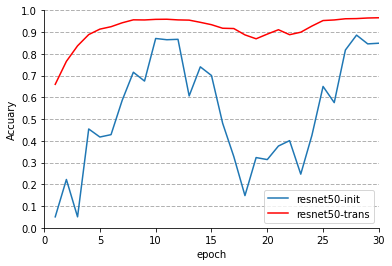

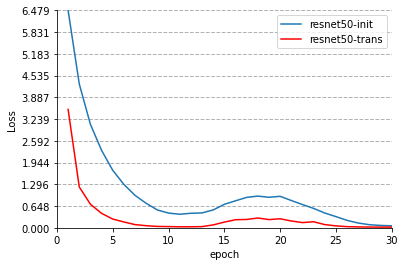

In [46]:
#绘制acc图
draw(len(epoch_x),7,epoch_x,epoch_acc_init,epoch_acc_trans,"acc.jpg","resnet50")
#绘制loss图
draw(len(epoch_x),7,epoch_x,epoch_init_ls,epoch_trans_ls,"loss.jpg","resnet50",y_aix=max(max(epoch_init_ls,epoch_trans_ls)),type='loss')